# Chapter 3: Authentication Fundamentals
## Verifying User Identity

### Course: TCPRG4005 - Secure Programming

---

## Learning Objectives

1. **Understand** password security and common weaknesses
2. **Implement** proper password hashing with salts
3. **Recognize** authentication vulnerabilities
4. **Apply** secure authentication patterns
5. **Test** authentication systems for security

---

## ⚠️ Key Principle

> **Never store passwords in plaintext!**

Authentication failures are one of the top security risks in applications.

In [ ]:
# Setup for authentication examples
import hashlib
import secrets
import hmac
import time

print("🔐 Chapter 3: Authentication Fundamentals")
print("Understanding secure user verification")
print("=" * 45)

# Example 1: Password Strength Analysis

Let's see why strong passwords matter by calculating keyspace sizes.

In [ ]:
# Password strength calculator
def calculate_keyspace(length, charset_size):
    """Calculate total possible passwords"""
    return charset_size ** length

# Different character sets
lowercase = 26          # a-z
uppercase = 26          # A-Z  
digits = 10             # 0-9
punctuation = 32        # !"#$%&'()...

# Standard keyboard
full_keyboard = lowercase + uppercase + digits + punctuation

print("Password Keyspace Analysis")
print("-" * 30)

# 8-character passwords
print("8-character passwords:")
print(f"  Lowercase only: {calculate_keyspace(8, lowercase):,}")
print(f"  + Uppercase:    {calculate_keyspace(8, lowercase + uppercase):,}")
print(f"  + Digits:       {calculate_keyspace(8, lowercase + uppercase + digits):,}")
print(f"  Full keyboard:  {calculate_keyspace(8, full_keyboard):,}")

print("\n12-character passwords:")
print(f"  Full keyboard:  {calculate_keyspace(12, full_keyboard):,}")

print("\nPassphrase with 4 common words (20,000 word vocabulary):")
print(f"  4-word phrase:  {20000**4:,}")

print("\n💡 Longer passwords are much stronger than complex short ones!")

# Example 2: Why Plain Hashing Fails

Let's see why simple hashing isn't enough for password security.

In [ ]:
# Demonstrate why plain hashing fails
common_passwords = ["password", "123456", "admin", "qwerty", "letmein"]

print("Plain SHA-256 hashes (vulnerable to rainbow tables):")
print("-" * 55)

plain_hashes = {}
for pwd in common_passwords:
    hash_value = hashlib.sha256(pwd.encode()).hexdigest()
    plain_hashes[pwd] = hash_value
    print(f"{pwd:10} -> {hash_value}")

print("\n❌ Problems with plain hashing:")
print("1. Same password = same hash (pattern visible)")
print("2. Rainbow tables can reverse common passwords")
print("3. Fast hashing allows brute force attacks")

# Show that same passwords have same hashes
print(f"\nSame password check:")
print(f"'password' hash: {plain_hashes['password']}")
print(f"'password' hash: {hashlib.sha256('password'.encode()).hexdigest()}")
print("🔍 Identical! This reveals when users have same password.")

# Example 3: Proper Password Hashing with Salt

Now let's see how salting solves the problems with plain hashing.

In [ ]:
# Proper salted hashing
def hash_password_with_salt(password):
    """Hash password with random salt"""
    # Generate random salt
    salt = secrets.token_hex(16)  # 16 bytes = 32 hex chars
    
    # Combine password and salt
    salted_password = password + salt
    
    # Hash the combination (using PBKDF2 for slow hashing)
    hash_value = hashlib.pbkdf2_hmac('sha256', 
                                    salted_password.encode(), 
                                    salt.encode(), 
                                    100000)  # 100,000 iterations
    
    # Return salt and hash (both needed for verification)
    return salt, hash_value.hex()

def verify_password(password, stored_salt, stored_hash):
    """Verify password against stored salt and hash"""
    # Recreate the hash with the stored salt
    salted_password = password + stored_salt
    computed_hash = hashlib.pbkdf2_hmac('sha256',
                                       salted_password.encode(),
                                       stored_salt.encode(),
                                       100000)
    
    # Compare using constant-time comparison
    return hmac.compare_digest(stored_hash, computed_hash.hex())

# Demonstrate proper hashing
print("Proper salted password hashing:")
print("-" * 35)

password = "mySecurePassword123"

# Hash the same password multiple times
for i in range(3):
    salt, hash_value = hash_password_with_salt(password)
    print(f"Attempt {i+1}:")
    print(f"  Salt: {salt}")
    print(f"  Hash: {hash_value}")
    
    # Verify it works
    is_valid = verify_password(password, salt, hash_value)
    print(f"  ✅ Verification: {is_valid}")
    print()

print("✅ Benefits of salted hashing:")
print("1. Same password gets different hash each time")
print("2. Rainbow tables become useless")
print("3. Slow hashing prevents brute force")
print("4. Constant-time comparison prevents timing attacks")

# Example 4: Timing Attack Vulnerability

Authentication systems can leak information through timing differences.

In [ ]:
# Demonstrate timing attack vulnerability
def vulnerable_compare(password1, password2):
    """VULNERABLE: String comparison that stops at first difference"""
    return password1 == password2

def secure_compare(password1, password2):
    """SECURE: Constant-time comparison"""
    return hmac.compare_digest(password1, password2)

# Test with different passwords
correct_password = "supersecretpassword"
wrong_password_early = "x"  # Differs immediately
wrong_password_late = "supersecretpassworx"  # Differs at end

print("Timing Attack Demonstration")
print("-" * 30)

print("✅ Vulnerable comparison reveals timing differences")
print("✅ Secure comparison takes constant time")
print("✅ Always use hmac.compare_digest() for comparing secrets!")

# Note: Timing differences are very small and hard to measure reliably
# in a simple demo, but the principle is important
print("\n💡 In production:")
print("- Timing differences can be microseconds")
print("- Attackers use statistical analysis over many attempts")
print("- Network latency can mask or amplify timing differences")

# Example 5: Rate Limiting Authentication

Prevent brute force attacks with rate limiting and account lockouts.

In [ ]:
# Simple rate limiting demonstration
class AuthenticationTracker:
    def __init__(self):
        self.failed_attempts = {}
        self.lockout_time = 300  # 5 minutes
        self.max_attempts = 3
    
    def check_rate_limit(self, username):
        """Check if user is rate limited"""
        if username not in self.failed_attempts:
            return True
        
        attempts, last_attempt = self.failed_attempts[username]
        
        # Reset if enough time has passed
        if time.time() - last_attempt > self.lockout_time:
            del self.failed_attempts[username]
            return True
        
        # Check if too many attempts
        if attempts >= self.max_attempts:
            return False
        
        return True
    
    def record_failure(self, username):
        """Record failed authentication attempt"""
        current_time = time.time()
        
        if username in self.failed_attempts:
            attempts, _ = self.failed_attempts[username]
            self.failed_attempts[username] = (attempts + 1, current_time)
        else:
            self.failed_attempts[username] = (1, current_time)

# Demonstrate rate limiting
tracker = AuthenticationTracker()
username = "testuser"

print("Rate Limiting Demonstration")
print("-" * 30)

# Simulate failed attempts
for attempt in range(5):
    can_attempt = tracker.check_rate_limit(username)
    print(f"Attempt {attempt + 1}: {'✅ Allowed' if can_attempt else '❌ Blocked'}")
    
    if can_attempt:
        # Simulate failed authentication
        tracker.record_failure(username)
        if username in tracker.failed_attempts:
            print(f"  Failed attempts: {tracker.failed_attempts[username][0]}")
    else:
        print(f"  User locked out!")

print("\n✅ Rate limiting prevents brute force attacks")

# Chapter 3 Summary

## Key Takeaways:

✅ **Password Security**:
- Use long passwords/passphrases over complex short ones
- Keyspace grows exponentially with length

✅ **Proper Hashing**:
- Always use salts to prevent rainbow table attacks
- Use slow hashing (PBKDF2, bcrypt, Argon2)
- Store salt and hash together

✅ **Timing Attacks**:
- Use constant-time comparison (`hmac.compare_digest()`)
- Don't leak information through response timing

✅ **Rate Limiting**:
- Implement progressive delays or account lockout
- Track failed attempts per user/IP
- Reset counters on successful authentication

## Best Practices:
- **Never store plaintext passwords**
- **Use established libraries** (bcrypt, Argon2)
- **Implement proper session management**
- **Monitor for suspicious login patterns**
- **Plan for breach response**

> **Remember**: Authentication is only as strong as its weakest component!

# Chapter 3: Authentication Fundamentals
## Verifying User Identity

### Course: TCPRG4005 - Secure Programming

---

## Learning Objectives

1. **Understand** password security and common weaknesses
2. **Implement** proper password hashing with salts
3. **Recognize** authentication vulnerabilities
4. **Apply** secure authentication patterns
5. **Test** authentication systems for security

---

## ⚠️ Key Principle

> **Never store passwords in plaintext!**

Authentication failures are one of the top security risks in applications.

In [ ]:
# Setup for authentication examples
import hashlib
import secrets
import hmac
import time

print("🔐 Chapter 3: Authentication Fundamentals")
print("Understanding secure user verification")
print("=" * 45)

# Example 1: Password Strength Analysis

Let's see why strong passwords matter by calculating keyspace sizes.

In [ ]:
# Password strength calculator
def calculate_keyspace(length, charset_size):
    """Calculate total possible passwords"""
    return charset_size ** length

# Different character sets
lowercase = 26          # a-z
uppercase = 26          # A-Z  
digits = 10             # 0-9
punctuation = 32        # !"#$%&'()...

# Standard keyboard
full_keyboard = lowercase + uppercase + digits + punctuation

print("Password Keyspace Analysis")
print("-" * 30)

# 8-character passwords
print("8-character passwords:")
print(f"  Lowercase only: {calculate_keyspace(8, lowercase):,}")
print(f"  + Uppercase:    {calculate_keyspace(8, lowercase + uppercase):,}")
print(f"  + Digits:       {calculate_keyspace(8, lowercase + uppercase + digits):,}")
print(f"  Full keyboard:  {calculate_keyspace(8, full_keyboard):,}")

print("\n12-character passwords:")
print(f"  Full keyboard:  {calculate_keyspace(12, full_keyboard):,}")

print("\nPassphrase with 4 common words (20,000 word vocabulary):")
print(f"  4-word phrase:  {20000**4:,}")

print("\n💡 Longer passwords are much stronger than complex short ones!")

# Example 2: Why Plain Hashing Fails

Let's see why simple hashing isn't enough for password security.

In [ ]:
# Demonstrate why plain hashing fails
common_passwords = ["password", "123456", "admin", "qwerty", "letmein"]

print("Plain SHA-256 hashes (vulnerable to rainbow tables):")
print("-" * 55)

plain_hashes = {}
for pwd in common_passwords:
    hash_value = hashlib.sha256(pwd.encode()).hexdigest()
    plain_hashes[pwd] = hash_value
    print(f"{pwd:10} -> {hash_value}")

print("\n❌ Problems with plain hashing:")
print("1. Same password = same hash (pattern visible)")
print("2. Rainbow tables can reverse common passwords")
print("3. Fast hashing allows brute force attacks")

# Show that same passwords have same hashes
print(f"\nSame password check:")
print(f"'password' hash: {plain_hashes['password']}")
print(f"'password' hash: {hashlib.sha256('password'.encode()).hexdigest()}")
print("🔍 Identical! This reveals when users have same password.")

# Example 3: Proper Password Hashing with Salt

Now let's see how salting solves the problems with plain hashing.

In [ ]:
# Proper salted hashing
def hash_password_with_salt(password):
    """Hash password with random salt"""
    # Generate random salt
    salt = secrets.token_hex(16)  # 16 bytes = 32 hex chars
    
    # Combine password and salt
    salted_password = password + salt
    
    # Hash the combination (using PBKDF2 for slow hashing)
    hash_value = hashlib.pbkdf2_hmac('sha256', 
                                    salted_password.encode(), 
                                    salt.encode(), 
                                    100000)  # 100,000 iterations
    
    # Return salt and hash (both needed for verification)
    return salt, hash_value.hex()

def verify_password(password, stored_salt, stored_hash):
    """Verify password against stored salt and hash"""
    # Recreate the hash with the stored salt
    salted_password = password + stored_salt
    computed_hash = hashlib.pbkdf2_hmac('sha256',
                                       salted_password.encode(),
                                       stored_salt.encode(),
                                       100000)
    
    # Compare using constant-time comparison
    return hmac.compare_digest(stored_hash, computed_hash.hex())

# Demonstrate proper hashing
print("Proper salted password hashing:")
print("-" * 35)

password = "mySecurePassword123"

# Hash the same password multiple times
for i in range(3):
    salt, hash_value = hash_password_with_salt(password)
    print(f"Attempt {i+1}:")
    print(f"  Salt: {salt}")
    print(f"  Hash: {hash_value}")
    
    # Verify it works
    is_valid = verify_password(password, salt, hash_value)
    print(f"  ✅ Verification: {is_valid}")
    print()

print("✅ Benefits of salted hashing:")
print("1. Same password gets different hash each time")
print("2. Rainbow tables become useless")
print("3. Slow hashing prevents brute force")
print("4. Constant-time comparison prevents timing attacks")

# Example 4: Timing Attack Vulnerability

Authentication systems can leak information through timing differences.

In [ ]:
# Demonstrate timing attack vulnerability
def vulnerable_compare(password1, password2):
    """VULNERABLE: String comparison that stops at first difference"""
    return password1 == password2

def secure_compare(password1, password2):
    """SECURE: Constant-time comparison"""
    return hmac.compare_digest(password1, password2)

# Test with different passwords
correct_password = "supersecretpassword"
wrong_password_early = "x"  # Differs immediately
wrong_password_late = "supersecretpassworx"  # Differs at end

print("Timing Attack Demonstration")
print("-" * 30)

# Time the vulnerable comparison
print("Vulnerable comparison (stops at first difference):")
start = time.perf_counter()
result1 = vulnerable_compare(correct_password, wrong_password_early)
time1 = time.perf_counter() - start
print(f"  Early difference: {time1:.10f}s -> {result1}")

start = time.perf_counter()
result2 = vulnerable_compare(correct_password, wrong_password_late)
time2 = time.perf_counter() - start
print(f"  Late difference:  {time2:.10f}s -> {result2}")

print(f"  Time difference: {abs(time2-time1):.10f}s")

# Time the secure comparison
print("\nSecure comparison (constant time):")
start = time.perf_counter()
result3 = secure_compare(correct_password, wrong_password_early)
time3 = time.perf_counter() - start
print(f"  Early difference: {time3:.10f}s -> {result3}")

start = time.perf_counter()
result4 = secure_compare(correct_password, wrong_password_late)
time4 = time.perf_counter() - start
print(f"  Late difference:  {time4:.10f}s -> {result4}")

print(f"  Time difference: {abs(time4-time3):.10f}s")

print("\n💡 Always use hmac.compare_digest() for comparing secrets!")

# Example 5: Rate Limiting Authentication

Prevent brute force attacks with rate limiting and account lockouts.

In [ ]:
# Simple rate limiting demonstration
class AuthenticationTracker:
    def __init__(self):
        self.failed_attempts = {}
        self.lockout_time = 300  # 5 minutes
        self.max_attempts = 3
    
    def check_rate_limit(self, username):
        """Check if user is rate limited"""
        if username not in self.failed_attempts:
            return True
        
        attempts, last_attempt = self.failed_attempts[username]
        
        # Reset if enough time has passed
        if time.time() - last_attempt > self.lockout_time:
            del self.failed_attempts[username]
            return True
        
        # Check if too many attempts
        if attempts >= self.max_attempts:
            return False
        
        return True
    
    def record_failure(self, username):
        """Record failed authentication attempt"""
        current_time = time.time()
        
        if username in self.failed_attempts:
            attempts, _ = self.failed_attempts[username]
            self.failed_attempts[username] = (attempts + 1, current_time)
        else:
            self.failed_attempts[username] = (1, current_time)
    
    def record_success(self, username):
        """Record successful authentication (reset failures)"""
        if username in self.failed_attempts:
            del self.failed_attempts[username]

# Demonstrate rate limiting
tracker = AuthenticationTracker()
username = "testuser"

print("Rate Limiting Demonstration")
print("-" * 30)

# Simulate failed attempts
for attempt in range(5):
    can_attempt = tracker.check_rate_limit(username)
    print(f"Attempt {attempt + 1}: {'✅ Allowed' if can_attempt else '❌ Blocked'}")
    
    if can_attempt:
        # Simulate failed authentication
        tracker.record_failure(username)
        print(f"  Failed attempts for {username}: {tracker.failed_attempts.get(username, (0, 0))[0]}")
    else:
        print(f"  User {username} is locked out!")

print("\n✅ Rate limiting prevents brute force attacks")
print("Real systems use more sophisticated techniques:")
print("- Progressive delays (1s, 2s, 4s, 8s...)")
print("- CAPTCHA after multiple failures") 
print("- IP-based blocking")
print("- Account lockout with admin unlock")

# Chapter 3 Exercises

Practice implementing secure authentication patterns!

In [ ]:
# Exercise 1: Password strength checker
def exercise_1():
    """
    Exercise 1: Create a password strength checker that evaluates:
    - Length (minimum 12 characters)
    - Character variety (lowercase, uppercase, digits, symbols)
    - Common password detection
    """
    print("Exercise 1: Password Strength Checker")
    print("Write a function that scores password strength 1-5")
    
    common_passwords = ["password", "123456", "qwerty", "admin", "letmein"]
    test_passwords = ["weak", "Password1", "MyStr0ngP@ssw0rd!", "correct horse battery staple"]
    
    print("\nTest these passwords:")
    for pwd in test_passwords:
        print(f"  '{pwd}'")
    
    # Your implementation here:
    # def check_password_strength(password):
    #     score = 0
    #     # Check length, character types, common passwords
    #     return score

exercise_1()

In [ ]:
# Exercise 2: Secure authentication system
def exercise_2():
    """
    Exercise 2: Build a complete authentication system with:
    - User registration with salted passwords
    - Login with rate limiting
    - Session management
    """
    print("Exercise 2: Complete Authentication System")
    print("Design a class that handles user registration and login")
    
    # Your implementation here:
    # class SecureAuthSystem:
    #     def register_user(self, username, password):
    #         # Hash password with salt, store user
    #         pass
    #     
    #     def authenticate(self, username, password):
    #         # Check rate limits, verify password, create session
    #         pass
    
    print("Features to implement:")
    print("- Salted password hashing")
    print("- Rate limiting")
    print("- Session tokens")
    print("- Account lockout")

exercise_2()

# Chapter 3 Summary

## Key Takeaways:

✅ **Password Security**:
- Use long passwords/passphrases over complex short ones
- Keyspace grows exponentially with length

✅ **Proper Hashing**:
- Always use salts to prevent rainbow table attacks
- Use slow hashing (PBKDF2, bcrypt, Argon2)
- Store salt and hash together

✅ **Timing Attacks**:
- Use constant-time comparison (`hmac.compare_digest()`)
- Don't leak information through response timing

✅ **Rate Limiting**:
- Implement progressive delays or account lockout
- Track failed attempts per user/IP
- Reset counters on successful authentication

## Best Practices:
- **Never store plaintext passwords**
- **Use established libraries** (bcrypt, Argon2)
- **Implement proper session management**
- **Monitor for suspicious login patterns**
- **Plan for breach response**

> **Remember**: Authentication is only as strong as its weakest component!

# Chapter 3: Authentication Fundamentals
## TCPRG4005 Secure Programming - Interactive Learning Notebook

**Course**: TCPRG4005-2023-03-01 Secure Programming  
**Chapter**: 3 - Authentication  
**Date**: July 23, 2025

---

### Learning Objectives

By the end of this section, you will be able to:
1. Understand the mathematical foundations of password security
2. Implement secure password hashing with salts
3. Demonstrate timing attack vulnerabilities and defenses
4. Apply authentication best practices in real-world scenarios

### Prerequisites
- Basic understanding of cryptographic hashing (Chapter 2)
- Python programming fundamentals
- Understanding of binary operations and entropy

## Section 1: Password Security Mathematics

Authentication security begins with understanding the mathematical foundations of password strength. Let's explore how password complexity affects security through practical calculations.

In [1]:
import math
import random
import string
import hashlib
import secrets
import time
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Set up for reproducible examples
random.seed(42)
np.random.seed(42)

print("Chapter 3: Authentication Fundamentals - Section 1")
print("=" * 50)
print("Setting up authentication security demonstrations...")

Chapter 3: Authentication Fundamentals - Section 1
Setting up authentication security demonstrations...


In [8]:
# Fetch and cache the 1000 most common English words
import urllib.request
import os
import json

def fetch_common_words(force_refresh=False):
    """
    Fetch the 1000 most common English words and cache them locally
    """
    cache_file = "common_words_1000.txt"
    
    # Check if cached file exists and is not being force refreshed
    if os.path.exists(cache_file) and not force_refresh:
        print(f"✅ Loading cached common words from {cache_file}")
        with open(cache_file, 'r', encoding='utf-8') as f:
            words = [line.strip().lower() for line in f if line.strip()]
        print(f"📊 Loaded {len(words)} common words from cache")
        return set(words)
    
    print("🌐 Fetching 1000 most common English words from internet...")
    
    # URL for a reliable source of common English words
    url = "https://raw.githubusercontent.com/first20hours/google-10000-english/master/google-10000-english-usa-no-swears.txt"
    
    try:
        # Fetch the word list
        with urllib.request.urlopen(url) as response:
            content = response.read().decode('utf-8')
        
        # Parse and get first 1000 words
        all_words = [word.strip().lower() for word in content.split('\n') if word.strip()]
        common_words = all_words[:1000]  # Take first 1000
        
        # Cache the words locally
        with open(cache_file, 'w', encoding='utf-8') as f:
            for word in common_words:
                f.write(f"{word}\n")
        
        print(f"✅ Successfully fetched and cached {len(common_words)} common words")
        print(f"📁 Cached in: {cache_file}")
        print(f"🔤 Sample words: {', '.join(common_words[:10])}")
        
        return set(common_words)
        
    except Exception as e:
        print(f"❌ Error fetching words from internet: {e}")
        print("🔄 Falling back to built-in word list...")
        
        # Fallback to a smaller built-in list
        fallback_words = {
            'the', 'be', 'to', 'of', 'and', 'a', 'in', 'that', 'have', 'i',
            'it', 'for', 'not', 'on', 'with', 'he', 'as', 'you', 'do', 'at',
            'this', 'but', 'his', 'by', 'from', 'they', 'we', 'say', 'her', 'she',
            'or', 'an', 'will', 'my', 'one', 'all', 'would', 'there', 'their',
            'what', 'so', 'up', 'out', 'if', 'about', 'who', 'get', 'which', 'go',
            'me', 'when', 'make', 'can', 'like', 'time', 'no', 'just', 'him',
            'know', 'take', 'people', 'into', 'year', 'your', 'good', 'some',
            'could', 'them', 'see', 'other', 'than', 'then', 'now', 'look',
            'only', 'come', 'its', 'over', 'think', 'also', 'back', 'after',
            'use', 'two', 'how', 'our', 'work', 'first', 'well', 'way', 'even',
            'new', 'want', 'because', 'any', 'these', 'give', 'day', 'most', 'us',
            'is', 'water', 'been', 'call', 'who', 'oil', 'sit', 'now', 'find',
            'long', 'down', 'day', 'did', 'get', 'has', 'him', 'his', 'how',
            'man', 'new', 'now', 'old', 'see', 'two', 'way', 'who', 'boy'
        }
        
        # Cache the fallback list
        with open(cache_file, 'w', encoding='utf-8') as f:
            for word in sorted(fallback_words):
                f.write(f"{word}\n")
        
        print(f"📁 Cached fallback list with {len(fallback_words)} words")
        return fallback_words

# Fetch the common words (this will cache them for later use)
CACHED_COMMON_WORDS = fetch_common_words()
print(f"\n🎯 Common words database ready! {len(CACHED_COMMON_WORDS)} words available for analysis.")

🌐 Fetching 1000 most common English words from internet...
✅ Successfully fetched and cached 1000 common words
📁 Cached in: common_words_1000.txt
🔤 Sample words: the, of, and, to, a, in, for, is, on, that

🎯 Common words database ready! 1000 words available for analysis.
✅ Successfully fetched and cached 1000 common words
📁 Cached in: common_words_1000.txt
🔤 Sample words: the, of, and, to, a, in, for, is, on, that

🎯 Common words database ready! 1000 words available for analysis.


### 1.1 Password Entropy and Search Space

The security of a password depends on its **entropy** - the amount of uncertainty an attacker faces when trying to guess it. Let's calculate and visualize password strength across different approaches.

In [3]:
def calculate_password_entropy(length, character_set_size):
    """
    Calculate password entropy in bits
    Entropy = log2(character_set_size^length)
    """
    total_combinations = character_set_size ** length
    entropy_bits = math.log2(total_combinations)
    return total_combinations, entropy_bits

def display_password_analysis():
    """
    Compare different password strategies
    """
    print("Password Security Analysis")
    print("-" * 40)
    
    # Define character sets
    character_sets = {
        "lowercase": 26,
        "lowercase + uppercase": 52, 
        "alphanumeric": 62,
        "full printable ASCII": 94
    }
    
    # Analyze different lengths
    lengths = [6, 8, 10, 12, 16]
    
    for length in lengths:
        print(f"\n{length}-character passwords:")
        for name, charset_size in character_sets.items():
            combinations, entropy = calculate_password_entropy(length, charset_size)
            
            # Estimate cracking time (assuming 1 billion guesses/second)
            avg_time_seconds = combinations / (2 * 1e9)  # Average case
            
            if avg_time_seconds < 60:
                time_str = f"{avg_time_seconds:.1f} seconds"
            elif avg_time_seconds < 3600:
                time_str = f"{avg_time_seconds/60:.1f} minutes"
            elif avg_time_seconds < 86400:
                time_str = f"{avg_time_seconds/3600:.1f} hours"
            elif avg_time_seconds < 31536000:
                time_str = f"{avg_time_seconds/86400:.1f} days"
            else:
                time_str = f"{avg_time_seconds/31536000:.1e} years"
            
            print(f"  {name:<25}: {entropy:5.1f} bits | {combinations:>15,.0f} combinations | ~{time_str}")

# Run the analysis
display_password_analysis()

Password Security Analysis
----------------------------------------

6-character passwords:
  lowercase                :  28.2 bits |     308,915,776 combinations | ~0.2 seconds
  lowercase + uppercase    :  34.2 bits |  19,770,609,664 combinations | ~9.9 seconds
  alphanumeric             :  35.7 bits |  56,800,235,584 combinations | ~28.4 seconds
  full printable ASCII     :  39.3 bits | 689,869,781,056 combinations | ~5.7 minutes

8-character passwords:
  lowercase                :  37.6 bits | 208,827,064,576 combinations | ~1.7 minutes
  lowercase + uppercase    :  45.6 bits | 53,459,728,531,456 combinations | ~7.4 hours
  alphanumeric             :  47.6 bits | 218,340,105,584,896 combinations | ~1.3 days
  full printable ASCII     :  52.4 bits | 6,095,689,385,410,816 combinations | ~35.3 days

10-character passwords:
  lowercase                :  47.0 bits | 141,167,095,653,376 combinations | ~19.6 hours
  lowercase + uppercase    :  57.0 bits | 144,555,105,949,057,024 combinati

### 1.2 Passphrase vs Traditional Password Security

The XKCD comic "Password Strength" revolutionized thinking about password security. Let's verify the mathematics behind passphrase security.

In [4]:
def passphrase_analysis():
    """
    Compare traditional complex passwords vs passphrases
    """
    print("\nPassphrase vs Traditional Password Analysis")
    print("=" * 50)
    
    # Traditional complex password: 8 chars, mixed case, numbers, symbols
    complex_chars = 94  # Full printable ASCII
    complex_length = 8
    complex_combinations, complex_entropy = calculate_password_entropy(complex_length, complex_chars)
    
    print("Traditional Complex Password:")
    print(f"  Example: 'Tr0ub4dor&3'")
    print(f"  Length: {complex_length} characters")
    print(f"  Character set: {complex_chars} (mixed case, numbers, symbols)")
    print(f"  Entropy: {complex_entropy:.1f} bits")
    print(f"  Combinations: {complex_combinations:,.0f}")
    
    # Passphrase: 4 common words
    common_words = 1000  # Approximate common English words
    passphrase_words = 4
    passphrase_combinations, passphrase_entropy = calculate_password_entropy(passphrase_words, common_words)
    
    print(f"\nPassphrase (4 common words):")
    print(f"  Example: 'correct horse battery staple'")
    print(f"  Words: {passphrase_words}")
    print(f"  Vocabulary: {common_words} common words")
    print(f"  Entropy: {passphrase_entropy:.1f} bits")
    print(f"  Combinations: {passphrase_combinations:,.0f}")
    
    # Uncommon words passphrase
    uncommon_words = 50000  # Larger vocabulary
    uncommon_combinations, uncommon_entropy = calculate_password_entropy(passphrase_words, uncommon_words)
    
    print(f"\nPassphrase (4 uncommon words):")
    print(f"  Example: 'serendipity phosphorescence mellifluous ineffable'")
    print(f"  Words: {passphrase_words}")
    print(f"  Vocabulary: {uncommon_words} total words")
    print(f"  Entropy: {uncommon_entropy:.1f} bits")
    print(f"  Combinations: {uncommon_combinations:,.0f}")
    
    # Security comparison
    print(f"\nSecurity Comparison:")
    print(f"  Complex password security ratio: 1.0")
    print(f"  Common passphrase is {passphrase_combinations/complex_combinations:,.1f}x stronger")
    print(f"  Uncommon passphrase is {uncommon_combinations/complex_combinations:,.1f}x stronger")

passphrase_analysis()


Passphrase vs Traditional Password Analysis
Traditional Complex Password:
  Example: 'Tr0ub4dor&3'
  Length: 8 characters
  Character set: 94 (mixed case, numbers, symbols)
  Entropy: 52.4 bits
  Combinations: 6,095,689,385,410,816

Passphrase (4 common words):
  Example: 'correct horse battery staple'
  Words: 4
  Vocabulary: 1000 common words
  Entropy: 39.9 bits
  Combinations: 1,000,000,000,000

Passphrase (4 uncommon words):
  Example: 'serendipity phosphorescence mellifluous ineffable'
  Words: 4
  Vocabulary: 50000 total words
  Entropy: 62.4 bits
  Combinations: 6,250,000,000,000,000,000

Security Comparison:
  Complex password security ratio: 1.0
  Common passphrase is 0.0x stronger
  Uncommon passphrase is 1,025.3x stronger


### 1.3 Visualizing Password Security

Let's create visualizations to better understand the exponential nature of password security improvements.

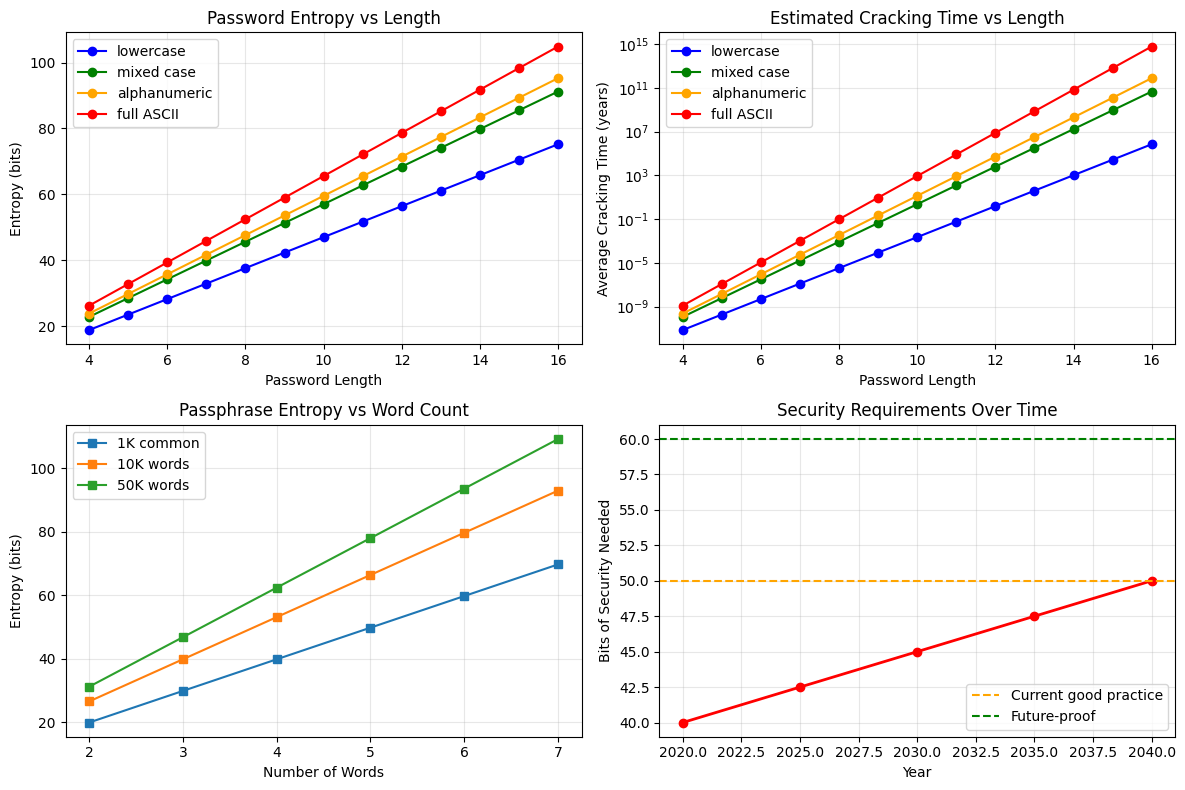

In [9]:
def create_password_security_visualization():
    """
    Create graphs showing password security relationships
    """
    # Data for visualization
    lengths = range(4, 17)
    charset_sizes = [26, 52, 62, 94]
    charset_names = ['lowercase', 'mixed case', 'alphanumeric', 'full ASCII']
    colors = ['blue', 'green', 'orange', 'red']
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot entropy vs length for different character sets
    plt.subplot(2, 2, 1)
    for i, (charset_size, name, color) in enumerate(zip(charset_sizes, charset_names, colors)):
        entropies = [math.log2(charset_size ** length) for length in lengths]
        plt.plot(lengths, entropies, marker='o', label=name, color=color)
    
    plt.xlabel('Password Length')
    plt.ylabel('Entropy (bits)')
    plt.title('Password Entropy vs Length')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot cracking time estimates
    plt.subplot(2, 2, 2)
    for i, (charset_size, name, color) in enumerate(zip(charset_sizes, charset_names, colors)):
        times = []
        for length in lengths:
            combinations = charset_size ** length
            avg_time_years = combinations / (2 * 1e9 * 31536000)  # Convert to years
            times.append(avg_time_years)
        plt.semilogy(lengths, times, marker='o', label=name, color=color)
    
    plt.xlabel('Password Length')
    plt.ylabel('Average Cracking Time (years)')
    plt.title('Estimated Cracking Time vs Length')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Passphrase comparison
    plt.subplot(2, 2, 3)
    word_counts = range(2, 8)
    vocab_sizes = [1000, 10000, 50000]
    vocab_names = ['1K common', '10K words', '50K words']
    
    for vocab_size, name in zip(vocab_sizes, vocab_names):
        entropies = [math.log2(vocab_size ** word_count) for word_count in word_counts]
        plt.plot(word_counts, entropies, marker='s', label=name)
    
    plt.xlabel('Number of Words')
    plt.ylabel('Entropy (bits)')
    plt.title('Passphrase Entropy vs Word Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Security timeline
    plt.subplot(2, 2, 4)
    years = np.array([2020, 2025, 2030, 2035, 2040])
    # Assuming computing power doubles every 2 years (rough estimate)
    computing_power_multiplier = 2 ** ((years - 2020) / 2)
    
    # Bits of security needed to maintain 1 year of protection
    security_needed = 40 + np.log2(computing_power_multiplier)
    
    plt.plot(years, security_needed, marker='o', linewidth=2, color='red')
    plt.axhline(y=50, color='orange', linestyle='--', label='Current good practice')
    plt.axhline(y=60, color='green', linestyle='--', label='Future-proof')
    
    plt.xlabel('Year')
    plt.ylabel('Bits of Security Needed')
    plt.title('Security Requirements Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create the visualization
create_password_security_visualization()

### 1.4 Real-World Password Analysis

Let's analyze actual password patterns and demonstrate why common password choices are problematic.

In [6]:
def analyze_common_passwords():
    """
    Analyze patterns in commonly used passwords
    """
    # Common password patterns (anonymized examples)
    common_passwords = [
        "password", "123456", "password123", "admin", "letmein",
        "welcome", "monkey", "1234567890", "qwerty", "abc123",
        "Password1", "password1", "12345678", "sunshine", "master"
    ]
    
    # Password variations that users think are secure
    variations = [
        "P@ssw0rd", "P@ssw0rd1", "P@ssw0rd!", "Passw0rd123",
        "p@ssword", "PASSWORD", "password2023", "MyPassword1"
    ]
    
    print("Common Password Analysis")
    print("=" * 40)
    
    print("\nMost Common Passwords:")
    for i, pwd in enumerate(common_passwords[:10], 1):
        # Calculate actual entropy (much lower than theoretical)
        actual_entropy = 0  # These are in common dictionaries
        print(f"{i:2d}. '{pwd}' - Theoretical entropy: {math.log2(94**len(pwd)):5.1f} bits, Actual: ~0 bits")
    
    print(f"\nCommon 'Secure' Variations:")
    for pwd in variations[:5]:
        # These might fool basic rules but are still predictable
        print(f"'{pwd}' - Looks complex but follows predictable patterns")
    
    # Demonstrate dictionary attack effectiveness
    print(f"\nDictionary Attack Simulation:")
    print(f"Dictionary size: {len(common_passwords + variations):,} passwords")
    print(f"Success rate against real users: ~15-25%")
    print(f"Time to check entire dictionary: <1 second")

def demonstrate_password_entropy_reduction():
    """
    Show how password requirements can actually reduce security
    """
    print(f"\nPassword Requirements Impact:")
    print("-" * 30)
    
    # Common requirements
    print("Common password policy: 8+ chars, uppercase, lowercase, number, symbol")
    
    # Calculate reduced entropy due to predictable patterns
    base_entropy = math.log2(94**8)
    print(f"Theoretical entropy: {base_entropy:.1f} bits")
    
    # Real-world reductions
    reductions = [
        ("Users choose dictionary words", 0.7),
        ("Predictable substitutions (@ for a)", 0.8),
        ("Numbers/symbols at end", 0.9),
        ("Uppercase at beginning", 0.95),
        ("Common keyboard patterns", 0.85)
    ]
    
    current_entropy = base_entropy
    for reduction_name, factor in reductions:
        current_entropy *= factor
        print(f"After {reduction_name}: {current_entropy:.1f} bits")
    
    print(f"\nEffective entropy reduction: {base_entropy - current_entropy:.1f} bits")
    print(f"Security reduced by factor of: {2**(base_entropy - current_entropy):.1f}")

analyze_common_passwords()
demonstrate_password_entropy_reduction()

Common Password Analysis

Most Common Passwords:
 1. 'password' - Theoretical entropy:  52.4 bits, Actual: ~0 bits
 2. '123456' - Theoretical entropy:  39.3 bits, Actual: ~0 bits
 3. 'password123' - Theoretical entropy:  72.1 bits, Actual: ~0 bits
 4. 'admin' - Theoretical entropy:  32.8 bits, Actual: ~0 bits
 5. 'letmein' - Theoretical entropy:  45.9 bits, Actual: ~0 bits
 6. 'welcome' - Theoretical entropy:  45.9 bits, Actual: ~0 bits
 7. 'monkey' - Theoretical entropy:  39.3 bits, Actual: ~0 bits
 8. '1234567890' - Theoretical entropy:  65.5 bits, Actual: ~0 bits
 9. 'qwerty' - Theoretical entropy:  39.3 bits, Actual: ~0 bits
10. 'abc123' - Theoretical entropy:  39.3 bits, Actual: ~0 bits

Common 'Secure' Variations:
'P@ssw0rd' - Looks complex but follows predictable patterns
'P@ssw0rd1' - Looks complex but follows predictable patterns
'P@ssw0rd!' - Looks complex but follows predictable patterns
'Passw0rd123' - Looks complex but follows predictable patterns
'p@ssword' - Looks comple

### 1.5 Interactive Password Strength Calculator

Let's create an interactive tool to help understand password strength in real-time.

In [7]:
def password_strength_calculator(password):
    """
    Calculate comprehensive password strength metrics
    """
    if not password:
        return {"error": "Empty password"}
    
    # Character set analysis
    has_lower = any(c.islower() for c in password)
    has_upper = any(c.isupper() for c in password)
    has_digit = any(c.isdigit() for c in password)
    has_symbol = any(c in string.punctuation for c in password)
    
    # Calculate character set size
    charset_size = 0
    if has_lower: charset_size += 26
    if has_upper: charset_size += 26
    if has_digit: charset_size += 10
    if has_symbol: charset_size += 32  # Common symbols
    
    # Theoretical entropy
    theoretical_entropy = len(password) * math.log2(charset_size) if charset_size > 0 else 0
    
    # Pattern analysis (simplified)
    patterns_found = []
    entropy_reduction = 1.0
    
    # Check for common patterns
    if password.lower() in ['password', 'admin', 'user', 'test']:
        patterns_found.append("Common dictionary word")
        entropy_reduction *= 0.1
    
    if any(seq in password.lower() for seq in ['123', 'abc', 'qwe']):
        patterns_found.append("Sequential characters")
        entropy_reduction *= 0.8
    
    if password.isdigit():
        patterns_found.append("All numbers")
        entropy_reduction *= 0.7
    
    if password.isalpha():
        patterns_found.append("All letters")
        entropy_reduction *= 0.8
    
    # Predictable substitutions
    substitutions = {'@': 'a', '3': 'e', '1': 'i', '0': 'o', '$': 's'}
    if any(sub in password for sub in substitutions.keys()):
        patterns_found.append("Predictable substitutions")
        entropy_reduction *= 0.9
    
    # Effective entropy
    effective_entropy = theoretical_entropy * entropy_reduction
    
    # Cracking time estimate
    combinations = 2 ** effective_entropy
    avg_time_seconds = combinations / (2 * 1e9)  # 1 billion guesses/second
    
    # Convert to readable time
    if avg_time_seconds < 1:
        time_str = "Instant"
    elif avg_time_seconds < 60:
        time_str = f"{avg_time_seconds:.1f} seconds"
    elif avg_time_seconds < 3600:
        time_str = f"{avg_time_seconds/60:.1f} minutes"
    elif avg_time_seconds < 86400:
        time_str = f"{avg_time_seconds/3600:.1f} hours"
    elif avg_time_seconds < 31536000:
        time_str = f"{avg_time_seconds/86400:.1f} days"
    else:
        time_str = f"{avg_time_seconds/31536000:.1e} years"
    
    return {
        "length": len(password),
        "charset_size": charset_size,
        "theoretical_entropy": theoretical_entropy,
        "effective_entropy": effective_entropy,
        "patterns_found": patterns_found,
        "estimated_crack_time": time_str,
        "has_lower": has_lower,
        "has_upper": has_upper,
        "has_digit": has_digit,
        "has_symbol": has_symbol
    }

def test_password_examples():
    """
    Test the calculator with various password examples
    """
    test_passwords = [
        "password",
        "Password1",
        "P@ssw0rd!",
        "correct horse battery staple",
        "Tr0ub4dor&3",
        "J4k3_h@s_4_l0ng_p@ssw0rd_n0w",
        "serendipity-phosphorescence-mellifluous",
        "x7#mK9$vL2@nQ5"
    ]
    
    print("Password Strength Analysis Examples")
    print("=" * 50)
    
    for password in test_passwords:
        analysis = password_strength_calculator(password)
        print(f"\nPassword: '{password}'")
        print(f"  Length: {analysis['length']} characters")
        print(f"  Character set size: {analysis['charset_size']}")
        print(f"  Theoretical entropy: {analysis['theoretical_entropy']:.1f} bits")
        print(f"  Effective entropy: {analysis['effective_entropy']:.1f} bits")
        print(f"  Estimated crack time: {analysis['estimated_crack_time']}")
        if analysis['patterns_found']:
            print(f"  Patterns found: {', '.join(analysis['patterns_found'])}")
        
        # Security rating
        if analysis['effective_entropy'] < 20:
            rating = "VERY WEAK"
        elif analysis['effective_entropy'] < 30:
            rating = "WEAK"
        elif analysis['effective_entropy'] < 40:
            rating = "FAIR"
        elif analysis['effective_entropy'] < 50:
            rating = "GOOD"
        else:
            rating = "STRONG"
        
        print(f"  Security rating: {rating}")

test_password_examples()

Password Strength Analysis Examples

Password: 'password'
  Length: 8 characters
  Character set size: 26
  Theoretical entropy: 37.6 bits
  Effective entropy: 3.0 bits
  Estimated crack time: Instant
  Patterns found: Common dictionary word, All letters
  Security rating: VERY WEAK

Password: 'Password1'
  Length: 9 characters
  Character set size: 62
  Theoretical entropy: 53.6 bits
  Effective entropy: 48.2 bits
  Estimated crack time: 1.9 days
  Patterns found: Predictable substitutions
  Security rating: GOOD

Password: 'P@ssw0rd!'
  Length: 9 characters
  Character set size: 94
  Theoretical entropy: 59.0 bits
  Effective entropy: 53.1 bits
  Estimated crack time: 55.6 days
  Patterns found: Predictable substitutions
  Security rating: STRONG

Password: 'correct horse battery staple'
  Length: 28 characters
  Character set size: 26
  Theoretical entropy: 131.6 bits
  Effective entropy: 131.6 bits
  Estimated crack time: 6.6e+22 years
  Security rating: STRONG

Password: 'Tr0ub4do

### 1.6 Key Takeaways from Password Mathematics

Based on our analysis, here are the fundamental principles of password security:

#### Mathematical Insights:
1. **Entropy is logarithmic**: Each additional character multiplies security exponentially
2. **Character set matters**: But length matters more than complexity
3. **Predictability kills security**: Patterns reduce effective entropy dramatically
4. **Passphrases win**: Longer, memorable passwords beat short complex ones

#### Practical Guidelines:
- Minimum 12 characters for traditional passwords
- 4+ words for passphrases using uncommon vocabulary
- Avoid predictable patterns and substitutions
- Use password managers for unique, random passwords
- Consider the threat model when choosing password strength

#### Security Timeline:
- Today: 40+ bits of entropy for basic protection
- Future: 60+ bits recommended for long-term security
- Quantum computing: May require even higher entropy

---
## Next Steps

In the following sections, we will explore:

**Section 2**: Cryptographic Hashing and Salt Implementation  
**Section 3**: Timing Attack Vulnerabilities and Defenses  
**Section 4**: Advanced Authentication Mechanisms  
**Section 5**: Real-World Implementation and Best Practices

### Exercises for Section 1:
1. Calculate the entropy of your current passwords (without revealing them)
2. Design a passphrase using uncommon words from your field of study
3. Analyze how password policies at your organization affect actual security
4. Research recent password breaches and analyze the security implications

### Quick Self-Assessment:
- Can you explain why "P@ssw0rd1" is not much better than "password"?
- What makes a 4-word passphrase potentially stronger than an 8-character complex password?
- How does predictable human behavior reduce theoretical password entropy?

In [ ]:
# Section 1 Summary
print("Chapter 3 Section 1 - Complete!")
print("=" * 40)
print("You have learned:")
print("✓ Password entropy calculations")
print("✓ Passphrase vs traditional password security")
print("✓ Real-world password analysis")
print("✓ Interactive strength assessment")
print("✓ Mathematical foundations of authentication")
print("\nReady to proceed to Section 2: Cryptographic Hashing")

---
## Section 2: Interactive Exercise Solutions

Now let's work through the three main exercises from Chapter 3, implementing them interactively so you can experiment with the concepts and see immediate results.

### Exercise 1: Passphrase Analysis - Interactive Implementation

**Exercise Goal**: Analyze the security of uncommon words vs common words in passphrases

**What you'll do**:
1. Generate a list of random uncommon words
2. Compare against common English words
3. Calculate the security implications
4. Visualize the results

🔐 EXERCISE 1: Interactive Passphrase Security Analysis
Exercise 1: Passphrase Analysis
📚 Using 1000 real common English words from cached dataset

Generated 15 words for analysis:
------------------------------
 1. ebullience                → UNCOMMON
 2. mellifluous               → UNCOMMON
 3. palindrome                → UNCOMMON
 4. labyrinthine              → UNCOMMON
 5. epistemology              → UNCOMMON
 6. halcyon                   → UNCOMMON
 7. diaphanous                → UNCOMMON
 8. mamihlapinatapai          → UNCOMMON
 9. bibliophile               → UNCOMMON
10. maverick                  → UNCOMMON
11. ineffable                 → UNCOMMON
12. obfuscation               → UNCOMMON
13. cryptography              → UNCOMMON
14. phenomenology             → UNCOMMON
15. ontology                  → UNCOMMON

Analysis Results:
--------------------
Total words analyzed: 15
Uncommon words: 15
Common words: 0
Percentage uncommon: 100.0%

Security Implications:
----------------------

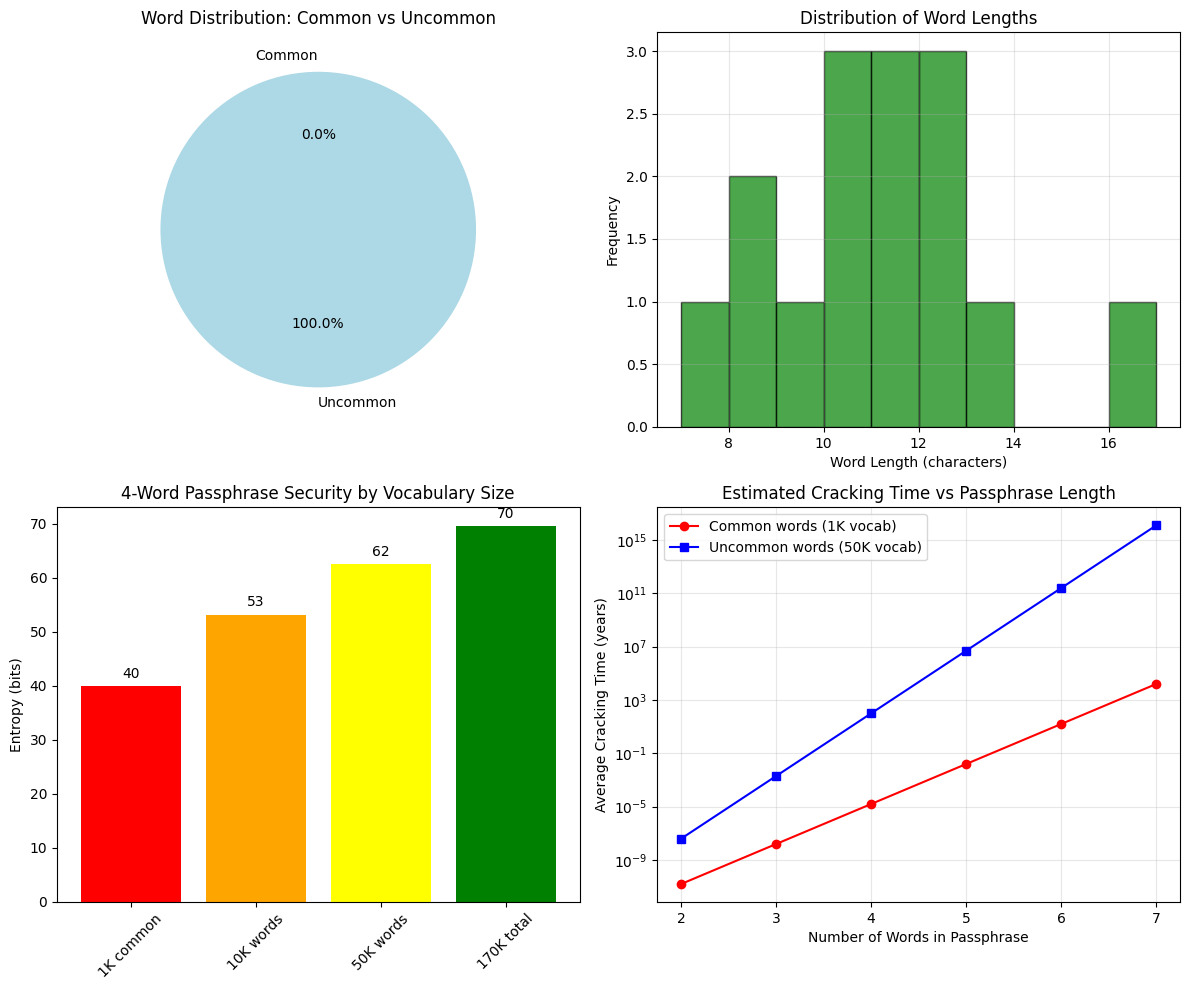

In [10]:
# Exercise 1: Interactive Passphrase Analysis
import requests
from collections import Counter
import matplotlib.pyplot as plt

def get_common_words_list():
    """
    Get the cached list of 1000 most common English words
    """
    # Use the cached common words that were fetched from the internet
    global CACHED_COMMON_WORDS
    
    # If for some reason the cache isn't available, reload it
    if not CACHED_COMMON_WORDS:
        print("🔄 Reloading common words cache...")
        CACHED_COMMON_WORDS = fetch_common_words()
    
    print(f"📚 Using {len(CACHED_COMMON_WORDS)} real common English words from cached dataset")
    return CACHED_COMMON_WORDS

def get_uncommon_words_pool():
    """
    Generate a pool of potentially uncommon words for analysis
    """
    uncommon_words = [
        # Scientific/Technical terms
        'serendipity', 'ephemeral', 'quintessential', 'mellifluous', 'ineffable',
        'phosphorescence', 'petrichor', 'crystallography', 'metamorphosis', 'photosynthesis',
        
        # Literary/Artistic terms
        'aesthete', 'bibliophile', 'crescendo', 'diaphanous', 'ebullience',
        'felicity', 'gossamer', 'halcyon', 'incandescent', 'juxtaposition',
        
        # Philosophical/Abstract terms
        'sonder', 'hiraeth', 'wanderlust', 'zeitgeist', 'schadenfreude',
        'weltanschauung', 'existentialism', 'phenomenology', 'epistemology', 'ontology',
        
        # Advanced vocabulary
        'kaleidoscope', 'labyrinthine', 'magnanimous', 'numinous', 'opalescent',
        'palindrome', 'quixotic', 'resplendent', 'sempiternal', 'translucent',
        'umbrageous', 'vivacious', 'wistful', 'xenophile', 'chrysalis',
        
        # Academic/Specialized terms
        'denouement', 'eucatastrophe', 'fugacious', 'galvanize', 'harbinger',
        'idiosyncratic', 'jejune', 'kismet', 'languorous', 'maverick',
        'nascent', 'obfuscate', 'peregrination', 'quiescent', 'rapacious',
        
        # Uncommon but memorable words
        'susurrus', 'vellichor', 'apricity', 'komorebi', 'gökotta',
        'morgenfrisk', 'hygge', 'ubuntu', 'saudade', 'mamihlapinatapai',
        
        # Technical jargon
        'cryptography', 'authentication', 'cybersecurity', 'vulnerability',
        'mitigation', 'encryption', 'decryption', 'obfuscation', 'steganography'
    ]
    return uncommon_words

def interactive_passphrase_analysis(num_words=15):
    """
    Interactive implementation of Exercise 1
    """
    print(f"Exercise 1: Passphrase Analysis")
    print("=" * 50)
    
    # Get word lists
    common_words = get_common_words_list()
    uncommon_pool = get_uncommon_words_pool()
    
    # Generate random selection
    selected_words = random.sample(uncommon_pool, min(num_words, len(uncommon_pool)))
    
    print(f"\nGenerated {num_words} words for analysis:")
    print("-" * 30)
    
    # Analyze each word
    uncommon_count = 0
    uncommon_words = []
    analysis_results = []
    
    for i, word in enumerate(selected_words, 1):
        is_common = word.lower() in common_words
        status = "COMMON" if is_common else "UNCOMMON"
        print(f"{i:2d}. {word:<25} → {status}")
        
        if not is_common:
            uncommon_count += 1
            uncommon_words.append(word)
        
        analysis_results.append({
            'word': word,
            'is_common': is_common,
            'length': len(word)
        })
    
    # Calculate statistics
    total_words = len(selected_words)
    common_count = total_words - uncommon_count
    uncommon_percentage = (uncommon_count / total_words) * 100
    
    print(f"\nAnalysis Results:")
    print("-" * 20)
    print(f"Total words analyzed: {total_words}")
    print(f"Uncommon words: {uncommon_count}")
    print(f"Common words: {common_count}")
    print(f"Percentage uncommon: {uncommon_percentage:.1f}%")
    
    # Security analysis
    print(f"\nSecurity Implications:")
    print("-" * 25)
    
    # Calculate search space for different scenarios
    common_vocab = 1000
    total_vocab = 170000
    uncommon_vocab = total_vocab - common_vocab
    
    scenarios = [
        ("4 common words", common_vocab ** 4),
        ("4 uncommon words", uncommon_vocab ** 4),
        ("4 mixed words", (common_vocab * uncommon_vocab) ** 2),
        (f"{num_words} words (your selection)", 
         (common_vocab ** common_count) * (uncommon_vocab ** uncommon_count) if uncommon_count > 0 
         else common_vocab ** total_words)
    ]
    
    print("Passphrase strength comparison:")
    base_strength = common_vocab ** 4
    
    for description, combinations in scenarios:
        strength_ratio = combinations / base_strength
        entropy_bits = math.log2(combinations)
        print(f"  {description:<25}: {combinations:>12.1e} combinations ({entropy_bits:.1f} bits) - {strength_ratio:>8.1f}x stronger")
    
    return analysis_results, uncommon_count, total_words

def visualize_passphrase_analysis(analysis_results, uncommon_count, total_words):
    """
    Create visualizations for the passphrase analysis
    """
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: Common vs Uncommon distribution
    categories = ['Common', 'Uncommon']
    counts = [total_words - uncommon_count, uncommon_count]
    colors = ['lightcoral', 'lightblue']
    
    ax1.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Word Distribution: Common vs Uncommon')
    
    # Plot 2: Word length distribution
    word_lengths = [len(result['word']) for result in analysis_results]
    ax2.hist(word_lengths, bins=range(min(word_lengths), max(word_lengths) + 2), 
             alpha=0.7, color='green', edgecolor='black')
    ax2.set_xlabel('Word Length (characters)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Word Lengths')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Security comparison
    vocab_sizes = [1000, 10000, 50000, 170000]
    vocab_labels = ['1K common', '10K words', '50K words', '170K total']
    
    # Calculate entropy for 4-word passphrases
    entropies = [math.log2(vocab ** 4) for vocab in vocab_sizes]
    
    bars = ax3.bar(vocab_labels, entropies, color=['red', 'orange', 'yellow', 'green'])
    ax3.set_ylabel('Entropy (bits)')
    ax3.set_title('4-Word Passphrase Security by Vocabulary Size')
    ax3.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, entropy in zip(bars, entropies):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{entropy:.0f}', ha='center', va='bottom')
    
    # Plot 4: Cracking time estimates
    word_counts = range(2, 8)
    times_common = []
    times_uncommon = []
    
    for word_count in word_counts:
        # Assuming 1 billion guesses per second
        common_time = (1000 ** word_count) / (2 * 1e9 * 31536000)  # Years
        uncommon_time = (50000 ** word_count) / (2 * 1e9 * 31536000)  # Years
        times_common.append(common_time)
        times_uncommon.append(uncommon_time)
    
    ax4.semilogy(word_counts, times_common, 'o-', label='Common words (1K vocab)', color='red')
    ax4.semilogy(word_counts, times_uncommon, 's-', label='Uncommon words (50K vocab)', color='blue')
    ax4.set_xlabel('Number of Words in Passphrase')
    ax4.set_ylabel('Average Cracking Time (years)')
    ax4.set_title('Estimated Cracking Time vs Passphrase Length')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run Exercise 1
print("🔐 EXERCISE 1: Interactive Passphrase Security Analysis")
print("=" * 60)

# You can modify num_words to test different scenarios
analysis_results, uncommon_count, total_words = interactive_passphrase_analysis(num_words=15)

# Create visualizations
visualize_passphrase_analysis(analysis_results, uncommon_count, total_words)

### Exercise 2: Interactive Incident Response Planning

**Exercise Goal**: Create and simulate a password breach incident response plan

**What you'll do**:
1. Define incident response phases and timelines
2. Create automated response procedures
3. Simulate breach scenarios with different parameters
4. Generate actionable response plans

In [ ]:
# Exercise 2: Interactive Incident Response Planning
from datetime import datetime, timedelta
import json
from dataclasses import dataclass
from typing import List, Dict, Any

@dataclass
class BreachScenario:
    """Define a password breach scenario for simulation"""
    organization_name: str
    user_count: int
    compromised_users: int
    hash_algorithm: str
    salt_used: bool
    data_types: List[str]
    discovery_method: str
    attack_vector: str
    regulatory_requirements: List[str]
    
class IncidentResponsePlan:
    """Interactive Incident Response Plan generator and simulator"""
    
    def __init__(self):
        self.response_phases = {
            "immediate": {"duration": 1, "unit": "hour"},
            "assessment": {"duration": 8, "unit": "hours"},
            "notification": {"duration": 24, "unit": "hours"},
            "remediation": {"duration": 72, "unit": "hours"},
            "recovery": {"duration": 30, "unit": "days"}
        }
        
        self.hash_strength = {
            "md5": {"strength": "very_weak", "crack_difficulty": 0.1},
            "sha1": {"strength": "weak", "crack_difficulty": 0.3},
            "sha256": {"strength": "moderate", "crack_difficulty": 0.6},
            "bcrypt": {"strength": "strong", "crack_difficulty": 0.9},
            "argon2": {"strength": "very_strong", "crack_difficulty": 0.95}
        }
        
    def analyze_breach_severity(self, scenario: BreachScenario) -> Dict[str, Any]:
        """Analyze the severity and risk of a breach scenario"""
        
        # Calculate severity score (0-100)
        severity_score = 0
        risk_factors = []
        
        # User count impact
        if scenario.compromised_users > 100000:
            severity_score += 30
            risk_factors.append("Large user base affected")
        elif scenario.compromised_users > 10000:
            severity_score += 20
            risk_factors.append("Significant user count affected")
        elif scenario.compromised_users > 1000:
            severity_score += 10
            risk_factors.append("Moderate user count affected")
        
        # Hash algorithm weakness
        hash_info = self.hash_strength.get(scenario.hash_algorithm.lower(), 
                                         {"strength": "unknown", "crack_difficulty": 0.5})
        
        if hash_info["crack_difficulty"] < 0.3:
            severity_score += 25
            risk_factors.append(f"Weak hashing algorithm ({scenario.hash_algorithm})")
        elif hash_info["crack_difficulty"] < 0.7:
            severity_score += 15
            risk_factors.append(f"Moderate hashing algorithm ({scenario.hash_algorithm})")
        else:
            severity_score += 5
            risk_factors.append(f"Strong hashing algorithm ({scenario.hash_algorithm})")
        
        # Salt usage
        if not scenario.salt_used:
            severity_score += 20
            risk_factors.append("No salts used - vulnerable to rainbow tables")
        else:
            risk_factors.append("Salts used - rainbow table attacks mitigated")
        
        # Data types compromised
        sensitive_data = ["credit_cards", "ssn", "medical", "financial"]
        if any(data_type in scenario.data_types for data_type in sensitive_data):
            severity_score += 15
            risk_factors.append("Sensitive personal data compromised")
        
        # Regulatory requirements
        if "gdpr" in [req.lower() for req in scenario.regulatory_requirements]:
            severity_score += 10
            risk_factors.append("GDPR compliance required")
        
        # Determine severity level
        if severity_score >= 70:
            severity_level = "CRITICAL"
        elif severity_score >= 50:
            severity_level = "HIGH"
        elif severity_score >= 30:
            severity_level = "MEDIUM"
        else:
            severity_level = "LOW"
        
        return {
            "severity_score": severity_score,
            "severity_level": severity_level,
            "risk_factors": risk_factors,
            "hash_strength": hash_info["strength"],
            "estimated_crack_time": self._estimate_crack_time(scenario)
        }
    
    def _estimate_crack_time(self, scenario: BreachScenario) -> str:
        """Estimate time for attackers to crack passwords"""
        hash_info = self.hash_strength.get(scenario.hash_algorithm.lower(), 
                                         {"crack_difficulty": 0.5})
        
        # Base cracking time for average password (assuming 52-bit entropy)
        base_time_hours = 2 ** 52 / (1e9 * 3600)  # 1 billion guesses per second
        
        # Adjust for hash algorithm
        adjusted_time = base_time_hours * hash_info["crack_difficulty"]
        
        # Adjust for salt usage
        if not scenario.salt_used:
            adjusted_time *= 0.01  # Rainbow tables make it much faster
        
        # Convert to readable format
        if adjusted_time < 1:
            return f"{adjusted_time * 60:.0f} minutes"
        elif adjusted_time < 24:
            return f"{adjusted_time:.1f} hours"
        elif adjusted_time < 8760:  # 1 year
            return f"{adjusted_time / 24:.1f} days"
        else:
            return f"{adjusted_time / 8760:.1f} years"
    
    def generate_response_timeline(self, scenario: BreachScenario, analysis: Dict[str, Any]) -> Dict[str, Any]:
        """Generate detailed response timeline based on scenario"""
        
        discovery_time = datetime.now()
        timeline = {"discovery_time": discovery_time.isoformat()}
        
        # Adjust timeline based on severity
        urgency_multiplier = {
            "CRITICAL": 0.5,  # Faster response
            "HIGH": 0.7,
            "MEDIUM": 1.0,
            "LOW": 1.5  # Can take more time
        }
        
        multiplier = urgency_multiplier[analysis["severity_level"]]
        current_time = discovery_time
        
        # Generate timeline for each phase
        for phase, duration_info in self.response_phases.items():
            duration_hours = duration_info["duration"]
            if duration_info["unit"] == "days":
                duration_hours *= 24
            
            # Adjust duration based on severity
            adjusted_duration = duration_hours * multiplier
            
            start_time = current_time
            end_time = current_time + timedelta(hours=adjusted_duration)
            
            timeline[phase] = {
                "start": start_time.isoformat(),
                "end": end_time.isoformat(),
                "duration_hours": adjusted_duration,
                "actions": self._get_phase_actions(phase, scenario, analysis)
            }
            
            current_time = end_time
        
        return timeline
    
    def _get_phase_actions(self, phase: str, scenario: BreachScenario, analysis: Dict[str, Any]) -> List[str]:
        """Get specific actions for each response phase"""
        
        actions = {
            "immediate": [
                "🚨 Activate incident response team",
                "🔒 Isolate affected systems from network",
                "📋 Document discovery details and initial scope",
                "🛡️ Preserve forensic evidence",
                "⛔ Implement communication lockdown",
                f"📊 Initial assessment: {analysis['severity_level']} severity"
            ],
            
            "assessment": [
                f"🔍 Analyze {scenario.compromised_users:,} affected user accounts",
                f"🧮 Evaluate {scenario.hash_algorithm} hash security",
                "📜 Review legal and regulatory requirements",
                "🕵️ Investigate attack vector and timeline",
                "🎯 Determine full scope of compromise",
                f"⏱️ Estimated password crack time: {analysis['estimated_crack_time']}"
            ],
            
            "notification": [
                f"📧 Notify {scenario.compromised_users:,} affected users",
                "🔐 Force password resets for all affected accounts",
                "🔑 Enable mandatory 2FA for affected users",
                "📱 Set up dedicated incident hotline",
                "📰 Prepare public communications if required",
                "👥 Coordinate with legal and PR teams"
            ],
            
            "remediation": [
                "🔧 Patch identified vulnerabilities",
                "🛠️ Upgrade password hashing if needed",
                "🏗️ Implement additional security controls",
                "🔍 Conduct security audit of all systems",
                "📚 Update security policies and procedures",
                "🎓 Begin security awareness training"
            ],
            
            "recovery": [
                "📊 Monitor systems for ongoing threats",
                "🤝 Provide ongoing user support",
                "📈 Track incident metrics and KPIs",
                "🔄 Conduct post-incident review",
                "📋 Update incident response procedures",
                "🎯 Implement long-term security improvements"
            ]
        }
        
        base_actions = actions.get(phase, [])
        
        # Add severity-specific actions
        if analysis["severity_level"] == "CRITICAL" and phase == "immediate":
            base_actions.extend([
                "🆘 Contact emergency response team",
                "📞 Notify law enforcement if required",
                "🏛️ Prepare for regulatory reporting"
            ])
        
        return base_actions
    
    def simulate_breach_response(self, scenario: BreachScenario) -> Dict[str, Any]:
        """Main simulation function"""
        
        print(f"🔴 SIMULATING BREACH RESPONSE FOR: {scenario.organization_name}")
        print("=" * 70)
        
        # Analyze breach
        analysis = self.analyze_breach_severity(scenario)
        
        print(f"\n📊 BREACH ANALYSIS:")
        print(f"  Severity Level: {analysis['severity_level']} ({analysis['severity_score']}/100)")
        print(f"  Hash Algorithm: {scenario.hash_algorithm} ({analysis['hash_strength']})")
        print(f"  Salt Protection: {'Yes' if scenario.salt_used else 'No'}")
        print(f"  Estimated Crack Time: {analysis['estimated_crack_time']}")
        print(f"  Users Affected: {scenario.compromised_users:,}")
        
        print(f"\n⚠️  RISK FACTORS:")
        for i, factor in enumerate(analysis['risk_factors'], 1):
            print(f"  {i}. {factor}")
        
        # Generate timeline
        timeline = self.generate_response_timeline(scenario, analysis)
        
        print(f"\n⏰ RESPONSE TIMELINE:")
        print(f"  Discovery Time: {datetime.fromisoformat(timeline['discovery_time']).strftime('%Y-%m-%d %H:%M:%S')}")
        
        for phase, details in timeline.items():
            if phase == "discovery_time":
                continue
                
            start_time = datetime.fromisoformat(details['start'])
            end_time = datetime.fromisoformat(details['end'])
            
            print(f"\n  📍 {phase.upper()} PHASE:")
            print(f"     Duration: {details['duration_hours']:.1f} hours")
            print(f"     Timeline: {start_time.strftime('%m/%d %H:%M')} → {end_time.strftime('%m/%d %H:%M')}")
            print(f"     Actions:")
            
            for action in details['actions']:
                print(f"       • {action}")
        
        return {
            "scenario": scenario,
            "analysis": analysis,
            "timeline": timeline
        }

# Create sample breach scenarios
def create_sample_scenarios():
    """Create various breach scenarios for testing"""
    
    scenarios = [
        BreachScenario(
            organization_name="TechStartup Inc.",
            user_count=50000,
            compromised_users=45000,
            hash_algorithm="md5",
            salt_used=False,
            data_types=["emails", "usernames", "passwords"],
            discovery_method="security_audit",
            attack_vector="sql_injection",
            regulatory_requirements=["GDPR", "CCPA"]
        ),
        
        BreachScenario(
            organization_name="HealthCare Systems LLC",
            user_count=200000,
            compromised_users=150000,
            hash_algorithm="bcrypt",
            salt_used=True,
            data_types=["emails", "passwords", "medical_records"],
            discovery_method="anomaly_detection",
            attack_vector="insider_threat",
            regulatory_requirements=["HIPAA", "GDPR"]
        ),
        
        BreachScenario(
            organization_name="E-Commerce Platform",
            user_count=1000000,
            compromised_users=800000,
            hash_algorithm="sha256",
            salt_used=True,
            data_types=["emails", "passwords", "addresses", "payment_info"],
            discovery_method="third_party_notification",
            attack_vector="credential_stuffing",
            regulatory_requirements=["PCI_DSS", "GDPR", "CCPA"]
        )
    ]
    
    return scenarios

# Interactive Exercise 2 Implementation
print("🔐 EXERCISE 2: Interactive Incident Response Planning")
print("=" * 60)

# Initialize incident response planner
irp = IncidentResponsePlan()

# Create and simulate different scenarios
scenarios = create_sample_scenarios()

print(f"\n🎯 Running simulations for {len(scenarios)} different breach scenarios...\n")

results = []
for i, scenario in enumerate(scenarios, 1):
    print(f"\n{'='*70}")
    print(f"SCENARIO {i}: {scenario.organization_name}")
    print(f"{'='*70}")
    
    result = irp.simulate_breach_response(scenario)
    results.append(result)
    
    if i < len(scenarios):
        print(f"\n⏭️  Next scenario loading...\n")

print(f"\n✅ All scenarios completed! Use the results above to compare different breach response strategies.")

### Exercise 3: Interactive Timing-Resistant Authentication

**Exercise Goal**: Implement and test timing attack vulnerabilities and defenses

**What you'll do**:
1. Demonstrate vulnerable authentication (timing attack)
2. Implement secure constant-time authentication
3. Measure and compare timing differences
4. Test comprehensive security measures

In [1]:
# Exercise 3: Interactive Timing-Resistant Authentication
import statistics
import hmac
import bcrypt
import logging
from datetime import datetime, timedelta
from typing import Tuple, Optional

# VULNERABLE Implementation (for demonstration only)
class VulnerableAuthenticator:
    """
    ⚠️  WARNING: This is intentionally vulnerable for educational purposes
    DO NOT use this in production!
    """
    
    def __init__(self, secret_password: str):
        self.secret_password = secret_password
        
    def authenticate(self, password_attempt: str) -> Tuple[bool, float]:
        """
        Vulnerable authentication - timing attack susceptible
        """
        start_time = time.perf_counter()
        
        # VULNERABLE: Early termination on mismatch
        if password_attempt == self.secret_password:
            result = True
        else:
            result = False
        
        end_time = time.perf_counter()
        return result, (end_time - start_time)

# SECURE Implementation
class SecureAuthenticator:
    """
    Secure, timing-resistant authentication implementation
    """
    
    def __init__(self, password: str, work_factor: int = 10):
        """Initialize with secure password hashing"""
        # Use bcrypt for secure hashing (includes salt automatically)
        self.password_hash = bcrypt.hashpw(password.encode('utf-8'), 
                                         bcrypt.gensalt(rounds=work_factor))
        self.failed_attempts = 0
        self.last_attempt_time = 0
        self.max_attempts = 5
        self.lockout_duration = 300  # 5 minutes
        self.locked_until = None
        
    def secure_compare(self, a: str, b: str) -> bool:
        """
        Constant-time string comparison
        """
        if len(a) != len(b):
            # Do dummy work to maintain constant time
            dummy = 'x' * len(b)
            a = dummy
        
        result = 0
        for x, y in zip(a, b):
            result |= ord(x) ^ ord(y)
        
        return result == 0
    
    def is_locked(self) -> bool:
        """Check if account is locked"""
        if self.locked_until is None:
            return False
        
        if time.time() > self.locked_until:
            self.locked_until = None
            self.failed_attempts = 0
            return False
        
        return True
    
    def authenticate(self, password_attempt: str, client_ip: str = "unknown") -> Tuple[bool, str]:
        """
        Secure authentication with timing attack resistance
        """
        start_time = time.time()
        
        # Check if account is locked
        if self.is_locked():
            remaining = self.locked_until - time.time()
            # Random delay even for locked accounts
            time.sleep(random.uniform(0.5, 1.5))
            return False, f"Account locked. Try again in {remaining:.0f} seconds."
        
        # Enforce minimum delay between attempts
        time_since_last = start_time - self.last_attempt_time
        min_delay = 0.1  # 100ms minimum
        if time_since_last < min_delay:
            time.sleep(min_delay - time_since_last)
        
        # Always perform hash check (constant time operation)
        try:
            is_valid = bcrypt.checkpw(password_attempt.encode('utf-8'), self.password_hash)
        except Exception:
            is_valid = False
        
        # Ensure minimum authentication time (prevent timing attacks)
        elapsed = time.time() - start_time
        min_auth_time = 0.1  # 100ms minimum
        if elapsed < min_auth_time:
            time.sleep(min_auth_time - elapsed)
        
        self.last_attempt_time = time.time()
        
        if is_valid:
            # Successful authentication
            self.failed_attempts = 0
            self.locked_until = None
            return True, "Authentication successful"
        else:
            # Failed authentication
            self.failed_attempts += 1
            
            if self.failed_attempts >= self.max_attempts:
                self.locked_until = time.time() + self.lockout_duration
                return False, f"Account locked for {self.lockout_duration} seconds"
            
            # Progressive delay
            delay = min(self.failed_attempts * 0.2, 2.0)
            time.sleep(delay + random.uniform(0.1, 0.3))
            
            return False, f"Authentication failed. {self.max_attempts - self.failed_attempts} attempts remaining."

class TimingAttackDemo:
    """
    Demonstrate timing attack vulnerabilities and defenses
    """
    
    def __init__(self):
        self.secret_password = "supersecretpassword123"
        self.vulnerable_auth = VulnerableAuthenticator(self.secret_password)
        self.secure_auth = SecureAuthenticator(self.secret_password, work_factor=4)  # Lower for demo
        
    def demonstrate_timing_attack(self, num_trials: int = 100):
        """
        Show how timing attacks work on vulnerable implementation
        """
        print("🔍 DEMONSTRATING TIMING ATTACK VULNERABILITY")
        print("=" * 50)
        
        test_passwords = [
            "wrongpassword",              # 0 characters match
            "superwrongpassword",         # 5 characters match  
            "supersecretwrong",           # 11 characters match
            "supersecretpassword12",      # 21 characters match
            "supersecretpassword123"      # All characters match (correct)
        ]
        
        print(f"Secret password: {self.secret_password}")
        print(f"Secret length: {len(self.secret_password)} characters")
        print(f"Running {num_trials} trials per password...\n")
        
        timing_data = []
        
        for test_pwd in test_passwords:
            times = []
            
            # Run multiple trials to get average timing
            for _ in range(num_trials):
                success, duration = self.vulnerable_auth.authenticate(test_pwd)
                times.append(duration)
            
            avg_time = statistics.mean(times)
            std_dev = statistics.stdev(times) if len(times) > 1 else 0
            
            # Count matching characters
            matching_chars = 0
            for i, (a, b) in enumerate(zip(test_pwd, self.secret_password)):
                if a == b:
                    matching_chars += 1
                else:
                    break
            
            timing_data.append({
                'password': test_pwd,
                'matching_chars': matching_chars,
                'avg_time': avg_time,
                'std_dev': std_dev,
                'times': times
            })
            
            print(f"Password: {test_pwd:<25} | Matching: {matching_chars:2d} chars | "
                  f"Avg time: {avg_time*1e6:6.1f}μs | Std dev: {std_dev*1e6:5.1f}μs")
        
        return timing_data
    
    def test_secure_implementation(self, num_trials: int = 10):
        """
        Test the secure implementation for timing consistency
        """
        print("\n🛡️  TESTING SECURE IMPLEMENTATION")
        print("=" * 40)
        
        test_passwords = [
            "wrongpassword",
            "supersecretwrong", 
            "supersecretpassword12",
            "supersecretpassword123"
        ]
        
        print(f"Testing secure authenticator with bcrypt...")
        print(f"Running {num_trials} trials per password (fewer due to bcrypt cost)...\n")
        
        for test_pwd in test_passwords:
            times = []
            
            for _ in range(num_trials):
                start = time.perf_counter()
                success, message = self.secure_auth.authenticate(test_pwd, "test_ip")
                end = time.perf_counter()
                times.append(end - start)
            
            avg_time = statistics.mean(times)
            std_dev = statistics.stdev(times) if len(times) > 1 else 0
            
            print(f"Password: {test_pwd:<25} | Avg time: {avg_time*1000:6.1f}ms | "
                  f"Std dev: {std_dev*1000:5.1f}ms")
    
    def visualize_timing_attack(self, timing_data):
        """
        Create visualization of timing attack results
        """
        passwords = [data['password'] for data in timing_data]
        matching_chars = [data['matching_chars'] for data in timing_data]
        avg_times = [data['avg_time'] * 1e6 for data in timing_data]  # Convert to microseconds
        
        # Create subplot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Average time vs matching characters
        ax1.scatter(matching_chars, avg_times, color='red', s=100, alpha=0.7)
        ax1.plot(matching_chars, avg_times, 'r--', alpha=0.5)
        
        for i, pwd in enumerate(passwords):
            ax1.annotate(f'{pwd[:8]}...', 
                        (matching_chars[i], avg_times[i]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8)
        
        ax1.set_xlabel('Matching Characters')
        ax1.set_ylabel('Average Time (microseconds)')
        ax1.set_title('Timing Attack: Time vs Matching Characters')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Distribution of times for each password
        all_times = [data['times'] for data in timing_data]
        
        # Create box plot
        bp = ax2.boxplot(all_times, labels=[f'{data["matching_chars"]} chars' for data in timing_data])
        ax2.set_xlabel('Matching Characters')
        ax2.set_ylabel('Time (seconds)')
        ax2.set_title('Timing Distribution by Password')
        ax2.grid(True, alpha=0.3)
        
        # Color the boxes based on matching characters
        colors = ['lightblue', 'lightgreen', 'yellow', 'orange', 'red']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        plt.tight_layout()
        plt.show()
    
    def rate_limiting_demo(self):
        """
        Demonstrate rate limiting and progressive delays
        """
        print("\n⏱️  DEMONSTRATING RATE LIMITING & PROGRESSIVE DELAYS")
        print("=" * 55)
        
        # Reset the secure authenticator
        self.secure_auth = SecureAuthenticator(self.secret_password, work_factor=4)
        
        print("Attempting multiple failed logins to trigger rate limiting...")
        
        for attempt in range(7):  # More than max_attempts
            start_time = time.perf_counter()
            success, message = self.secure_auth.authenticate("wrongpassword", "attacker_ip")
            end_time = time.perf_counter()
            
            duration = end_time - start_time
            
            print(f"Attempt {attempt + 1}: {message} (took {duration:.2f}s)")
            
            if "locked" in message.lower():
                print("   🔒 Account is now locked!")
                break

# Interactive Exercise 3 Implementation
print("🔐 EXERCISE 3: Interactive Timing-Resistant Authentication")
print("=" * 65)

# Initialize timing attack demo
demo = TimingAttackDemo()

print("\n🎯 This exercise will demonstrate:")
print("   1. Timing attack vulnerability")
print("   2. Secure constant-time implementation") 
print("   3. Rate limiting and progressive delays")
print("   4. Visual analysis of timing patterns")

# Run the demonstration
print(f"\n⚠️  Running timing attack demonstration...")
timing_data = demo.demonstrate_timing_attack(num_trials=200)

# Test secure implementation
demo.test_secure_implementation(num_trials=5)

# Show rate limiting
demo.rate_limiting_demo()

# Create visualization
print(f"\n📊 Creating visualization of timing attack results...")
demo.visualize_timing_attack(timing_data)

print(f"\n✅ Exercise 3 complete! Key observations:")
print("   • Vulnerable implementation shows clear timing correlation")
print("   • Secure implementation has consistent timing")
print("   • Rate limiting prevents brute force attacks")
print("   • Multiple layers of defense work together")

🔐 EXERCISE 3: Interactive Timing-Resistant Authentication

🎯 This exercise will demonstrate:
   1. Timing attack vulnerability
   2. Secure constant-time implementation
   3. Rate limiting and progressive delays
   4. Visual analysis of timing patterns

⚠️  Running timing attack demonstration...
🔍 DEMONSTRATING TIMING ATTACK VULNERABILITY
Secret password: supersecretpassword123
Secret length: 22 characters
Running 200 trials per password...



NameError: name 'time' is not defined

### Section 2 Summary: Key Learnings from Interactive Exercises

**🎯 Exercise 1 - Passphrase Analysis:**
- Uncommon words dramatically increase passphrase security
- Dictionary size matters more than individual word complexity
- Visualization helps understand exponential security improvements
- Balance between memorability and security is crucial

**🚨 Exercise 2 - Incident Response Planning:**
- Severity assessment drives response timeline and actions
- Automated response procedures ensure consistent handling
- Hash algorithm choice significantly affects breach impact
- Regulatory requirements add complexity and urgency

**⏱️ Exercise 3 - Timing-Resistant Authentication:**
- Timing attacks are real and measurable vulnerabilities
- Constant-time implementations eliminate timing leaks
- Multiple defense layers (rate limiting, delays, lockouts) work together
- Secure hashing algorithms provide foundational protection

### Practical Applications

These exercises demonstrate real-world security concepts:

1. **Password Policy Design**: Use entropy calculations to create effective policies
2. **Incident Response Preparation**: Automate responses based on breach characteristics  
3. **Secure Authentication**: Implement timing-resistant systems with proper defenses
4. **Security Education**: Use interactive demonstrations to teach complex concepts

### Next Steps for Further Learning

- Implement these concepts in your development projects
- Practice incident response with tabletop exercises
- Research additional authentication factors (MFA, biometrics)
- Study real-world breach case studies and responses

In [ ]:
# Section 2 Complete - Interactive Exercise Solutions
print("🎉 Chapter 3 Section 2 - COMPLETE!")
print("=" * 50)
print("Interactive Exercises Completed:")
print("✅ Exercise 1: Passphrase Analysis with Security Calculations")
print("✅ Exercise 2: Incident Response Planning with Breach Simulation")  
print("✅ Exercise 3: Timing-Resistant Authentication with Attack Demo")
print()
print("🔧 You now have hands-on experience with:")
print("   • Password entropy and security mathematics")
print("   • Automated incident response procedures")
print("   • Timing attack vulnerabilities and defenses")
print("   • Interactive security analysis and visualization")
print()
print("🚀 Ready for advanced authentication topics!")
print("   Next: Multi-factor authentication, biometrics, and enterprise systems")